In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import sys
sys.path.append("..")
from utils import *
from merge_utils import *
import re

In [2]:
class FeatureEncode:
    def __init__(self, label):
        self.label = label
        self.code_map_dict = dict()
        self.mean_code_map_dict = dict()

    def replace_encode(self, data, f, cands):
        data['%s#encode' % f] = (data[f].isin(cands) * data[f]).replace(
            {cands[i]: (i + 1) for i in range(len(cands))})
    
    def mean_encode(self, data, f):
        if f not in self.mean_code_map_dict:
            count_table = data[[self.label, f]].groupby(f).agg(['count', 'sum'])[self.label]
            count_table['rate'] = count_table['sum'] / count_table['count']
            code_map = {k:v['rate'] for k,v in count_table.iterrows()}
            self.mean_code_map_dict[f] = code_map
        return data[f].map(self.mean_code_map_dict[f])
    
    def merge_encode(self, data, f, tol, max_intervals, include_nan=False):
        if f not in self.code_map_dict:
            merge_value_lst = [x for x in highFreq(data, f, self.label, tol, plot=False)
                               if x != 999999]
            merge_value = {}
            for i in range(len(merge_value_lst)):
                if str(merge_value_lst[i]) == 'nan':
                    merge_value['nan'] = i
                else:
                    merge_value[merge_value_lst[i]] = i
            merge_idx = data[f].isin(merge_value) | data[f].isnull()
            data_tmp = data[[self.label, f]].copy()
            if include_nan:
                data_tmp[f].fillna('nan', inplace=True)
            data_tmp.loc[merge_idx, f] = data_tmp.loc[merge_idx, f].map(merge_value)
            intervals_info = chiMerge(data_tmp[merge_idx], f, self.label, max_intervals)
            count_table = data[[self.label, f]].groupby(f).agg(['count', 'sum'])[self.label]
            count_table['rate'] = count_table['sum'] / count_table['count']
            code_map = {}
            if include_nan and 'nan' in merge_value:
                idx = merge_value['nan']
                for x in intervals_info:
                    if idx >= intervals_info[x]['bound'][0] and idx <= intervals_info[x]['bound'][1]:
                        code_map['nan'] = x
                        break
            for k, v in count_table.iterrows():
                if str(k) == 'nan':
                    k = 'nan'
                code = np.nan
                if k in merge_value:
                    idx = merge_value[k]
                    for x in intervals_info:
                        if idx >= intervals_info[x]['bound'][0] and idx <= intervals_info[x]['bound'][1]:
                            code = x
                            break
                else:
                    gap = {x: abs(v['rate'] - intervals_info[x]['num'][1] / intervals_info[x]['num'][0])
                           for x in intervals_info}
                    code = sorted(gap, key=lambda x: gap[x])[0] if gap else np.nan
                code_map[k] = code
            self.code_map_dict[f] = code_map
        if include_nan:
            res = data[f].fillna('nan').map(self.code_map_dict[f])
        else:
            res = data[f].map(self.code_map_dict[f])
        return res

    def main_trans(self, data, method='merge'):
        n = data.shape[0]
        for col in ['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + \
                   ['card%i' % i for i in range(1, 7)] + \
                   ['M%i' % i for i in range(1, 10)]:
            if method == 'merge':
                data['%s#encode' % col] = self.merge_encode(data, col, 10000, 5)
            elif method == 'mean':
                data['%s#encode' % col] = self.mean_encode(data, col)
                
    def main_id(self, data, method='merge'):
        for col in ['DeviceType', 'DeviceInfo'] + ['id_%i' % i for i in range(12, 39)]:
            if method == 'merge':
                data['%s#encode' % col] = self.merge_encode(data, col, 5000, 5, True)
            elif method == 'mean':
                data['%s#encode' % col] = self.mean_encode(data, col)

In [3]:
df_trans = pd.read_csv('./data/train_transaction.csv')
df_id = pd.read_csv('./data/train_identity.csv')

In [4]:
# 按时间分组
def splitMonth(data, day_nums=(31,31,28,31,30,31)):
    start_time = data['TransactionDT'].min()
    end_time = data['TransactionDT'].max()
    day = (data['TransactionDT']-start_time)//(86400)
    def encode_day(x):
        cumsum = 0
        for i in range(len(day_nums)):
            cumsum += day_nums[i]
            if x <= cumsum:
                return i
    data['#month'] = day.apply(encode_day)
splitMonth(df_trans)
df_trans['#month'].describe()

count    590540.000000
mean          2.258951
std           1.756788
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: #month, dtype: float64

In [5]:
df_trans.rename({'isFraud':'label'}, axis=1, inplace=True)
df_id = df_id.merge(df_trans[['TransactionID', 'label', '#month']], on='TransactionID', how='left')

In [6]:
df_trans_big = df_trans[df_trans['#month']!=5].copy()
print(df_trans_big.shape)
df_trans_oot = df_trans[df_trans['#month']==5].copy()
df_id_big = df_id[df_id['#month']!=5].copy()
df_id_oot = df_id[df_id['#month']==5].copy()

(505110, 395)


In [7]:
E = FeatureEncode('label')
E.main_trans(df_trans_big,)
E.main_trans(df_trans_oot,)
E.main_id(df_id_big,)
E.main_id(df_id_oot)

iv=0.5317
                   total     1      rate
ProductCD#encode                        
W                 372927  7714  0.020685
R                  33605  1224  0.036423
H                  30535  1421  0.046537
999999              8715   554  0.063569
C                  59328  6756  0.113875
iv=0.4574
                 total       1      rate
addr1#encode                            
 184.0         13174.0   181.0  0.013739
 191.0         12788.0   217.0  0.016969
 315.0         19777.0   336.0  0.016989
 264.0         34058.0   631.0  0.018527
 181.0         11898.0   243.0  0.020424
 299.0         39901.0   881.0  0.022080
 325.0         36504.0   915.0  0.025066
 441.0         17770.0   453.0  0.025492
 123.0         13688.0   351.0  0.025643
 126.0         13101.0   348.0  0.026563
 337.0         12965.0   346.0  0.026687
 204.0         35655.0   956.0  0.026813
 999999.0     148625.0  4124.0  0.027748
 272.0         17252.0   483.0  0.027997
 330.0         21342.0   713.0  0.033

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


iv=0.2640
                 total       1      rate
card6#encode                            
999999            45.0     0.0  0.000000
debit         375480.0  8975.0  0.023903
NaN              828.0    24.0  0.028986
credit        128757.0  8670.0  0.067336
iv=0.2141
              total        1      rate
M1#encode                             
999999         22.0      0.0  0.000000
T          258253.0   5198.0  0.020128
NaN        246835.0  12471.0  0.050524
iv=0.2361
              total        1      rate
M2#encode                             
T          231623.0   4249.0  0.018344
F           26652.0    949.0  0.035607
NaN        246835.0  12471.0  0.050524
iv=0.2425
              total        1      rate
M3#encode                             
T          203947.0   3510.0  0.017210
F           54328.0   1688.0  0.031071
NaN        246835.0  12471.0  0.050524
iv=0.4396
              total       1      rate
M4#encode                            
NaN        242556.0  4525.0  0.018655
M1   

iv=0.2774
                  total       1      rate
id_34#encode                             
match_status:2  52221.0  2007.0  0.038433
999999            405.0    21.0  0.051852
match_status:1  16205.0  1029.0  0.063499
NaN             57141.0  6546.0  0.114559
iv=0.2945
                total       1      rate
id_35#encode                           
NaN            2789.0    66.0  0.023664
T             68827.0  3048.0  0.044285
F             54356.0  6489.0  0.119380
iv=0.0497
                 total       1      rate
id_36#encode                            
NaN             2789.0    66.0  0.023664
T               6342.0   210.0  0.033113
F             116841.0  9327.0  0.079826
iv=0.0316
                total       1      rate
id_37#encode                           
NaN            2789.0    66.0  0.023664
F             26820.0  1704.0  0.063535
T             96363.0  7833.0  0.081286
iv=0.0797
                total       1      rate
id_38#encode                           
NaN          

In [8]:
id_features = searchRegex('.*#encode', df_id_big.columns)
tmp = list(df_trans_big.columns.drop(['TransactionID', 'label', 'TransactionDT', '#month']))
trans_features = []
for x in tmp:
    if '#' not in x:
        if '%s#encode'%x in tmp:
            trans_features.append('%s#encode'%x)
        else:
            trans_features.append(x)
features = trans_features + id_features

In [9]:
df_train_big = df_trans_big.merge(df_id_big[['TransactionID']+id_features], on='TransactionID', how='left')
df_train, df_test = split_data_v2(df_train_big, 0.2, 20190727)
df_test_oot = df_trans_oot.merge(df_id_oot[['TransactionID']+id_features], on='TransactionID', how='left')

In [10]:
features

['TransactionAmt',
 'ProductCD#encode',
 'card1#encode',
 'card2#encode',
 'card3#encode',
 'card4#encode',
 'card5#encode',
 'card6#encode',
 'addr1#encode',
 'addr2#encode',
 'dist1',
 'dist2',
 'P_emaildomain#encode',
 'R_emaildomain#encode',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1#encode',
 'M2#encode',
 'M3#encode',
 'M4#encode',
 'M5#encode',
 'M6#encode',
 'M7#encode',
 'M8#encode',
 'M9#encode',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',

In [11]:
from multiprocessing import Pool as ThreadPool
pool = ThreadPool(8)
#pool.close()
iv_dict_train = {}
iv_dict_oot = {}
def worker(x):
    iv_dict_train[x] = count(df_train_big, x, 12)[::-1]
    iv_dict_oot[x] = count(df_test_oot, x, 12)[::-1]
    print(iv_dict_train[x])
    print(iv_dict_oot[x])
for x in features:
    worker(x)
#pool.map(worker, features)

(0.1318523990954012,                      total     1      rate
TransactionAmt                            
(0.25, 25.0]         43792  2593  0.059212
(25.0, 33.0]         40419  1349  0.033375
(33.0, 43.036]       42075  1307  0.031064
(43.036, 50.0]       49317  1368  0.027739
(50.0, 57.95]        35150   637  0.018122
(57.95, 68.95]       42573  1197  0.028116
(68.95, 97.0]        42183  1781  0.042221
(97.0, 107.95]       46437   835  0.017981
(107.95, 125.0]      37733   946  0.025071
(125.0, 200.0]       44886  2078  0.046295
(200.0, 311.95]      39673  1614  0.040683
(311.95, 31937.391]  40872  1964  0.048052)
(0.1930709322922151,                    total    1      rate
TransactionAmt                         
(0.498, 25.576]     7126  562  0.078866
(25.576, 34.0]      8281  248  0.029948
(34.0, 43.95]       5967  216  0.036199
(43.95, 50.0]       7547  190  0.025176
(50.0, 58.95]       6974  100  0.014339
(58.95, 68.0]       6821  211  0.030934
(68.0, 97.0]        7376  278  0.03

(0.2178455201374097,                 total     1      rate
C1                                   
(-0.001, 1.0]  274267  6832  0.024910
(1.0, 2.0]      88806  2716  0.030584
(2.0, 3.0]      43405  1519  0.034996
(3.0, 4.0]      23989   959  0.039977
(4.0, 8.0]      33856  1967  0.058099
(8.0, 4685.0]   40787  3676  0.090127)
(0.24962283206008157,                total     1      rate
C1                                  
(-0.001, 1.0]  43018  1024  0.023804
(1.0, 2.0]     16265   466  0.028650
(2.0, 3.0]      7910   322  0.040708
(3.0, 4.0]      4856   212  0.043657
(4.0, 8.0]      6968   330  0.047359
(8.0, 1505.0]   6413   640  0.099797)
(0.2534720828100853,                 total     1      rate
C2                                   
(-0.001, 1.0]  274139  6313  0.023028
(1.0, 2.0]      87958  2877  0.032709
(2.0, 3.0]      42641  1609  0.037734
(3.0, 4.0]      23833  1255  0.052658
(4.0, 9.0]      37062  1890  0.050996
(9.0, 5691.0]   39477  3725  0.094359)
(0.3044065682798707,         

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.0,                  total      1     rate
C3                                    
(-0.001, 25.0]  505110  17669  0.03498)
(0.004311755161912751,       total     1      rate
C3                         
0.0   84945  2990  0.035199
1.0     424     4  0.009434
2.0      31     0  0.000000
3.0      15     0  0.000000
4.0       4     0  0.000000
5.0       1     0  0.000000
6.0       1     0  0.000000
7.0       2     0  0.000000
8.0       1     0  0.000000
9.0       4     0  0.000000
11.0      1     0  0.000000
26.0      1     0  0.000000)
(0.5728759901943237,                 total      1      rate
C4                                    
(-0.001, 1.0]  483337  12780  0.026441
(1.0, 2253.0]   21773   4889  0.224544)
(0.4375308546642706,                total     1      rate
C4                                  
(-0.001, 1.0]  80363  2168  0.026978
(1.0, 1107.0]   5067   826  0.163016)
(0.16610522336481623,                 total      1      rate
C5                                    
(-0.001, 1.0

(0.1807840495874886,                     total       1      rate
D4                                         
(-122.001, 0.0]  143491.0  5693.0  0.039675
(0.0, 2.0]         7150.0   979.0  0.136923
(2.0, 24.0]       28415.0  1726.0  0.060743
(24.0, 65.0]      29875.0   903.0  0.030226
(65.0, 138.0]     29432.0   813.0  0.027623
(138.0, 251.0]    29950.0   703.0  0.023472
(251.0, 373.0]    29573.0   582.0  0.019680
(373.0, 491.0]    30096.0   521.0  0.017311
(491.0, 835.0]    29458.0   396.0  0.013443
NaN              147670.0  5353.0  0.036250)
(0.23157220889228555,                   total       1      rate
D4                                       
(-0.001, 7.0]   26797.0  1307.0  0.048774
(7.0, 36.0]      5425.0   295.0  0.054378
(36.0, 85.0]     5271.0   159.0  0.030165
(85.0, 154.0]    5367.0   127.0  0.023663
(154.0, 274.0]   5276.0   159.0  0.030136
(274.0, 430.0]   5349.0    83.0  0.015517
(430.0, 580.0]   5376.0    93.0  0.017299
(580.0, 869.0]   5317.0    28.0  0.005266
NaN     

(0.45230026154364106,                    total        1      rate
D12                                        
(-83.001, 0.0]   37258.0   3637.0  0.097617
(0.0, 12.0]       4482.0    962.0  0.214636
(12.0, 86.0]      4569.0    700.0  0.153206
(86.0, 303.0]     4633.0    809.0  0.174617
(303.0, 634.0]    4621.0    240.0  0.051937
NaN             449547.0  11321.0  0.025183)
(0.6566328823404508,                   total       1      rate
D12                                      
(-0.001, 3.0]    6195.0   747.0  0.120581
(3.0, 15.0]       689.0   124.0  0.179971
(15.0, 90.5]      744.0   183.0  0.245968
(90.5, 306.0]     764.0   157.0  0.205497
(306.0, 648.0]    762.0    39.0  0.051181
NaN             76276.0  1744.0  0.022864)
(0.34544748392079705,                   total        1      rate
D13                                       
(-0.001, 2.0]   43415.0   4873.0  0.112242
(2.0, 44.0]      3972.0    516.0  0.129909
(44.0, 818.0]    4285.0    262.0  0.061144
NaN            453438.0  12018

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.24423517361348707,          total        1      rate
V3                               
 0.0      18.0      0.0  0.000000
 1.0  234572.0   4271.0  0.018208
 2.0   13521.0    508.0  0.037571
 3.0    1736.0    149.0  0.085829
 4.0     298.0     21.0  0.070470
 5.0      66.0     10.0  0.151515
 6.0      25.0      5.0  0.200000
 7.0       6.0      4.0  0.666667
 8.0       1.0      0.0  0.000000
NaN   254867.0  12701.0  0.049834)
(0.5297636080126277,         total       1      rate
V3                             
 0.0      2.0     0.0  0.000000
 1.0  56011.0   978.0  0.017461
 2.0   4242.0   123.0  0.028996
 3.0    599.0    33.0  0.055092
 4.0    105.0     4.0  0.038095
 5.0     27.0     0.0  0.000000
 6.0      9.0     0.0  0.000000
 7.0     12.0     0.0  0.000000
 8.0      2.0     0.0  0.000000
 9.0      1.0     0.0  0.000000
NaN   24420.0  1856.0  0.076003)
(0.22699668092191616,          total        1      rate
V4                               
 0.0   45888.0    891.0  0.019417
 1.0  1

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.03905346600544121,                   total        1      rate
V16                                       
(-0.001, 1.0]  435510.0  14112.0  0.032403
(1.0, 15.0]       613.0    125.0  0.203915
NaN             68987.0   3432.0  0.049749)
(0.770166587790527,         total       1      rate
V16                            
 0.0  69203.0  1293.0  0.018684
 1.0   9088.0  1235.0  0.135893
 2.0     49.0    11.0  0.224490
 3.0      1.0     0.0  0.000000
 4.0      3.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.0805141026365893,                   total        1      rate
V17                                       
(-0.001, 1.0]  434958.0  13860.0  0.031865
(1.0, 15.0]      1165.0    377.0  0.323605
NaN             68987.0   3432.0  0.049749)
(0.6769870857001581,         total       1      rate
V17                            
 0.0  67337.0  1279.0  0.018994
 1.0  10772.0  1196.0  0.111029
 2.0    154.0    39.0  0.253247
 3.0     49.0    15.0  0.306122
 4.0     20.0     8.0  0.400000
 5.0      7.0     2.0  0.285714
 6.0      2.0     0.0  0.000000
 7.0      1.0     0.0  0.000000
 8.0      1.0     0.0  0.000000
 9.0      1.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.0879092140105474,                   total        1      rate
V18                                       
(-0.001, 1.0]  434638.0  13789.0  0.031725
(1.0, 15.0]      1485.0    448.0  0.301684
NaN             68987.0   3432.0  0.049749)
(0.6729517731708365,         total       1      rate
V18                            
 0.0  67337.0  1279.0  0.018994
 1.0  10706.0  1192.0  0.111339
 2.0    185.0    43.0  0.232432
 3.0     71.0    15.0  0.211268
 4.0     33.0     8.0  0.242424
 5.0      7.0     2.0  0.285714
 6.0      2.0     0.0  0.000000
 7.0      1.0     0.0  0.000000
 8.0      1.0     0.0  0.000000
 9.0      1.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)
(0.057338891698415426,          total        1      rate
V19                              
 0.0   86563.0   2239.0  0.025866
 1.0  343536.0  11467.0  0.033379
 2.0    5665.0    474.0  0.083672
 3.0     318.0     53.0  0.166667
 4.0      27.0      3.0  0.111111
 5.0       3.0      1.0  0.333333
 6.0       1.0      0.0  0.000

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.049648070215349394,                   total        1      rate
V20                                       
(-0.001, 1.0]  422204.0  13298.0  0.031497
(1.0, 15.0]     13919.0    939.0  0.067462
NaN             68987.0   3432.0  0.049749)
(0.1014862334677751,         total       1      rate
V20                            
 0.0  14530.0   276.0  0.018995
 1.0  61513.0  2145.0  0.034871
 2.0   2152.0   110.0  0.051115
 3.0    132.0     8.0  0.060606
 4.0     16.0     0.0  0.000000
 5.0      1.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)
(0.46074302082559543,          total       1      rate
V21                             
 0.0  380843.0  8224.0  0.021594
 1.0   54927.0  5970.0  0.108690
 2.0     298.0    37.0  0.124161
 3.0      52.0     5.0  0.096154
 4.0       1.0     1.0  1.000000
 5.0       2.0     0.0  0.000000
NaN    68987.0  3432.0  0.049749)
(0.662232597694727,         total       1      rate
V21                            
 0.0  67377.0  1285.0  0.019072
 1.0  10910.0  

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()
F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.044175196363838105,                   total        1      rate
V26                                       
(-0.001, 1.0]  430741.0  13776.0  0.031982
(1.0, 13.0]      5382.0    461.0  0.085656
NaN             68987.0   3432.0  0.049749)
(0.06050193742495565,         total       1      rate
V26                            
 0.0   1034.0    27.0  0.026112
 1.0  76412.0  2452.0  0.032089
 2.0    852.0    56.0  0.065728
 3.0     41.0     4.0  0.097561
 4.0      5.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)
(0.025516494214932746,          total        1      rate
V27                              
 0.0  435814.0  14237.0  0.032668
 1.0     303.0      0.0  0.000000
 2.0       5.0      0.0  0.000000
 4.0       1.0      0.0  0.000000
NaN    68987.0   3432.0  0.049749)
(0.050150067527381825,         total       1      rate
V27                            
 0.0  78262.0  2539.0  0.032442
 1.0     82.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)
(0.025509483235896836,          tota

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.03972736305942559,                   total        1      rate
V32                                       
(-0.001, 1.0]  435124.0  14076.0  0.032349
(1.0, 15.0]       999.0    161.0  0.161161
NaN             68987.0   3432.0  0.049749)
(0.6662307745016237,         total       1      rate
V32                            
 0.0  66801.0  1253.0  0.018757
 1.0  11400.0  1275.0  0.111842
 2.0    116.0    11.0  0.094828
 3.0     23.0     0.0  0.000000
 4.0      4.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)
(0.5324608392767799,          total       1      rate
V33                             
 0.0  379659.0  7793.0  0.020526
 1.0   56070.0  6352.0  0.113287
 2.0     301.0    67.0  0.222591
 3.0      82.0    23.0  0.280488
 4.0       9.0     1.0  0.111111
 5.0       1.0     1.0  1.000000
 7.0       1.0     0.0  0.000000
NaN    68987.0  3432.0  0.049749)
(0.8105217856631161,         total       1      rate
V33                            
 0.0  68110.0  1207.0  0.017721
 1.0  10197.0  

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.03778956238494924,                   total        1      rate
V34                                       
(-0.001, 1.0]  435476.0  14116.0  0.032415
(1.0, 13.0]       647.0    121.0  0.187017
NaN             68987.0   3432.0  0.049749)
(0.7785131044075047,         total       1      rate
V34                            
 0.0  66873.0  1169.0  0.017481
 1.0  11416.0  1358.0  0.118956
 2.0     51.0    12.0  0.235294
 3.0      3.0     0.0  0.000000
 4.0      1.0     0.0  0.000000
NaN    7086.0   455.0  0.064211)
(0.12316378490675078,          total       1      rate
V35                             
 0.0  171903.0  8335.0  0.048487
 1.0  182505.0  3863.0  0.021167
 2.0    2930.0   118.0  0.040273
 3.0      62.0     0.0  0.000000
NaN   147710.0  5353.0  0.036240)
(0.28799952429272124,         total       1      rate
V35                            
 0.0  24648.0  1524.0  0.061831
 1.0  38882.0   715.0  0.018389
 2.0    614.0    10.0  0.016287
 3.0     27.0     2.0  0.074074
NaN   21259.0   

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.45046650969516006,          total       1      rate
V43                             
 0.0  303097.0  6364.0  0.020997
 1.0   49195.0  4816.0  0.097896
 2.0    4212.0   829.0  0.196819
 3.0     705.0   235.0  0.333333
 4.0     134.0    61.0  0.455224
 5.0      45.0     6.0  0.133333
 6.0       8.0     5.0  0.625000
 7.0       2.0     0.0  0.000000
 8.0       2.0     0.0  0.000000
NaN   147710.0  5353.0  0.036240)
(0.6940982076440798,         total       1      rate
V43                            
 0.0  55164.0  1008.0  0.018273
 1.0   7734.0  1014.0  0.131109
 2.0   1022.0   156.0  0.152642
 3.0    180.0    52.0  0.288889
 4.0     40.0     8.0  0.200000
 5.0     21.0     3.0  0.142857
 6.0      5.0     5.0  1.000000
 7.0      5.0     5.0  1.000000
NaN   21259.0   743.0  0.034950)
(0.3406135832528754,                   total       1      rate
V44                                      
(-0.001, 1.0]  337503.0  8837.0  0.026183
(1.0, 48.0]     19897.0  3479.0  0.174850
NaN            147

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()



(0.5488704103999564,         total       1      rate
V48                            
 0.0  39844.0  2105.0  0.052831
 1.0  23770.0   137.0  0.005764
 2.0    508.0     9.0  0.017717
 3.0     49.0     0.0  0.000000
NaN   21259.0   743.0  0.034950)
(0.4970701597925812,          total        1      rate
V49                              
 0.0  224008.0  11480.0  0.051248
 1.0  126112.0    701.0  0.005559
 2.0    6467.0    121.0  0.018710
 3.0     603.0     10.0  0.016584
 4.0     137.0      3.0  0.021898
 5.0      73.0      1.0  0.013699
NaN   147710.0   5353.0  0.036240)
(0.5401391483674591,         total       1      rate
V49                            
 0.0  39753.0  2100.0  0.052826
 1.0  23138.0   136.0  0.005878
 2.0   1137.0    12.0  0.010554
 3.0     88.0     3.0  0.034091
 4.0     50.0     0.0  0.000000
 5.0      5.0     0.0  0.000000
NaN   21259.0   743.0  0.034950)
(0.4396879942723859,          total       1      rate
V50                             
 0.0  297877.0  6016.0  0.02

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.09496209302413836,                   total        1      rate
V59                                       
(-0.001, 1.0]  433096.0  13293.0  0.030693
(1.0, 12.0]      2468.0    428.0  0.173420
NaN             69546.0   3948.0  0.056768)
(0.18805456471478454,                  total       1      rate
V59                                     
(-0.001, 1.0]  77416.0  2311.0  0.029852
(1.0, 16.0]      464.0   122.0  0.262931
NaN             7550.0   561.0  0.074305)
(0.1318898645226041,                   total        1      rate
V60                                       
(-0.001, 1.0]  431143.0  12931.0  0.029992
(1.0, 12.0]      4421.0    790.0  0.178693
NaN             69546.0   3948.0  0.056768)
(0.20081795253114149,                  total       1      rate
V60                                     
(-0.001, 1.0]  76815.0  2247.0  0.029252
(1.0, 16.0]     1065.0   186.0  0.174648
NaN             7550.0   561.0  0.074305)
(0.14617209817782845,          total        1      rate
V61          

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.43217812673710154,          total       1      rate
V64                             
 0.0  381243.0  8271.0  0.021695
 1.0   49432.0  4714.0  0.095363
 2.0    4066.0   582.0  0.143138
 3.0     598.0   125.0  0.209030
 4.0      91.0    22.0  0.241758
 5.0      44.0     7.0  0.159091
 6.0      84.0     0.0  0.000000
 7.0       6.0     0.0  0.000000
NaN    69546.0  3948.0  0.056768)
(0.6443176709386771,         total       1      rate
V64                            
 0.0  67419.0  1286.0  0.019075
 1.0   9115.0   976.0  0.107076
 2.0   1079.0   135.0  0.125116
 3.0    159.0    23.0  0.144654
 4.0     27.0     3.0  0.111111
 5.0     17.0     2.0  0.117647
 6.0     60.0     4.0  0.066667
 7.0      4.0     4.0  1.000000
NaN    7550.0   561.0  0.074305)
(0.055067810718308886,          total        1      rate
V65                              
 0.0     153.0      1.0  0.006536
 1.0  435411.0  13720.0  0.031510
NaN    69546.0   3948.0  0.056768)
(0.09326015624707615,         total       1   

(0.2256220473076817,                   total        1      rate
V77                                       
(-0.001, 1.0]  402309.0  11064.0  0.027501
(1.0, 30.0]     22116.0   2791.0  0.126198
NaN             80685.0   3814.0  0.047270)
(0.3467881981471224,                  total       1      rate
V77                                     
(-0.001, 1.0]  72696.0  1909.0  0.026260
(1.0, 14.0]     4255.0   623.0  0.146416
NaN             8479.0   462.0  0.054488)
(0.2803853328102758,                   total        1      rate
V78                                       
(-0.001, 1.0]  388978.0  10226.0  0.026289
(1.0, 2.0]      25936.0   1792.0  0.069093
(2.0, 30.0]      9511.0   1837.0  0.193145
NaN             80685.0   3814.0  0.047270)
(0.38777920913579655,                  total       1      rate
V78                                     
(-0.001, 1.0]  69508.0  1757.0  0.025278
(1.0, 2.0]      5428.0   347.0  0.063928
(2.0, 31.0]     2015.0   428.0  0.212407
NaN             8479.0   462.

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.0890781929741458,                   total        1      rate
V80                                       
(-0.001, 1.0]  421698.0  13253.0  0.031428
(1.0, 19.0]      2727.0    602.0  0.220755
NaN             80685.0   3814.0  0.047270)
(0.18598942823636244,                  total       1      rate
V80                                     
(-0.001, 1.0]  76402.0  2352.0  0.030785
(1.0, 15.0]      549.0   180.0  0.327869
NaN             8479.0   462.0  0.054488)
(0.13053990312127078,                   total        1      rate
V81                                       
(-0.001, 1.0]  419730.0  12860.0  0.030639
(1.0, 19.0]      4695.0    995.0  0.211928
NaN             80685.0   3814.0  0.047270)
(0.217841787327608,                  total       1      rate
V81                                     
(-0.001, 1.0]  75752.0  2258.0  0.029808
(1.0, 15.0]     1199.0   274.0  0.228524
NaN             8479.0   462.0  0.054488)
(0.10216783392906868,          total        1      rate
V82            

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.46701121063630674,          total       1      rate
V85                             
 0.0  367842.0  7790.0  0.021178
 1.0   51490.0  5291.0  0.102758
 2.0    4096.0   539.0  0.131592
 3.0     807.0   176.0  0.218092
 4.0     127.0    52.0  0.409449
 5.0      41.0     7.0  0.170732
 6.0      12.0     0.0  0.000000
 7.0      10.0     0.0  0.000000
NaN    80685.0  3814.0  0.047270)
(0.7019317885129922,         total       1      rate
V85                            
 0.0  67261.0  1287.0  0.019134
 1.0   8075.0   986.0  0.122105
 2.0   1226.0   196.0  0.159869
 3.0    180.0    29.0  0.161111
 4.0     89.0    22.0  0.247191
 5.0      6.0     2.0  0.333333
 6.0    109.0     5.0  0.045872
 7.0      5.0     5.0  1.000000
NaN    8479.0   462.0  0.054488)
(0.3415560788477236,                   total        1      rate
V86                                       
(-0.001, 1.0]  404500.0  10555.0  0.026094
(1.0, 30.0]     19925.0   3300.0  0.165621
NaN             80685.0   3814.0  0.047270)
(0.

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.5541371641920797,          total        1      rate
V91                              
 0.0  258283.0  12699.0  0.049167
 1.0  155874.0   1007.0  0.006460
 2.0    8855.0    129.0  0.014568
 3.0     924.0     12.0  0.012987
 4.0     295.0      6.0  0.020339
 5.0     188.0      1.0  0.005319
 6.0       6.0      1.0  0.166667
NaN    80685.0   3814.0  0.047270)
(0.5646101726531653,         total       1      rate
V91                            
 0.0  46852.0  2301.0  0.049112
 1.0  28247.0   197.0  0.006974
 2.0   1615.0    27.0  0.016718
 3.0    162.0     7.0  0.043210
 4.0     41.0     0.0  0.000000
 5.0     34.0     0.0  0.000000
NaN    8479.0   462.0  0.054488)
(0.495472030725589,          total       1      rate
V92                             
 0.0  362037.0  7395.0  0.020426
 1.0   60611.0  5990.0  0.098827
 2.0    1468.0   389.0  0.264986
 3.0     245.0    63.0  0.257143
 4.0      56.0    18.0  0.321429
 5.0       5.0     0.0  0.000000
 6.0       1.0     0.0  0.000000
 7.0       

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(4.428537947203086e-05,                    total        1      rate
V98                                        
(-0.001, 12.0]  504871.0  17658.0  0.034975
NaN                239.0     11.0  0.046025)
(0.004429608023732561,         total       1      rate
V98                            
 0.0  79935.0  2762.0  0.034553
 1.0   4506.0   190.0  0.042166
 2.0    793.0    28.0  0.035309
 3.0    102.0     8.0  0.078431
 4.0     17.0     0.0  0.000000
 5.0      2.0     0.0  0.000000
NaN      75.0     6.0  0.080000)
(0.013417684449701473,                   total        1      rate
V99                                       
(-0.001, 1.0]  423782.0  15350.0  0.036221
(1.0, 3.0]      50751.0   1227.0  0.024177
(3.0, 88.0]     30338.0   1081.0  0.035632
NaN               239.0     11.0  0.046025)
(0.041051771514360416,                  total       1      rate
V99                                     
(-0.001, 1.0]  66885.0  2558.0  0.038245
(1.0, 2.0]      6626.0   136.0  0.020525
(2.0, 4.0]      58

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.07669330255746631,          total        1      rate
V110                             
 0.0     135.0      1.0  0.007407
 1.0  501101.0  16952.0  0.033830
 2.0    3470.0    579.0  0.166859
 3.0     120.0     85.0  0.708333
 4.0      33.0     29.0  0.878788
 5.0       7.0      7.0  1.000000
 6.0       1.0      1.0  1.000000
 7.0       4.0      4.0  1.000000
NaN      239.0     11.0  0.046025)
(0.049876591823692036,         total       1      rate
V110                           
 0.0     39.0     0.0  0.000000
 1.0  84460.0  2874.0  0.034028
 2.0    838.0   101.0  0.120525
 3.0     16.0    11.0  0.687500
 4.0      2.0     2.0  1.000000
NaN      75.0     6.0  0.080000)
(0.1223590139203662,          total        1      rate
V111                             
 0.0     188.0      3.0  0.015957
 1.0  503456.0  17013.0  0.033792
 2.0    1056.0    500.0  0.473485
 3.0     117.0     95.0  0.811966
 4.0      34.0     27.0  0.794118
 5.0      12.0     12.0  1.000000
 6.0       2.0      2.0  1.000

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.13140095319143857,                   total        1      rate
V123                                      
(-0.001, 1.0]  492372.0  15846.0  0.032183
(1.0, 13.0]     12499.0   1812.0  0.144972
NaN               239.0     11.0  0.046025)
(0.13185516372478687,         total       1      rate
V123                           
 0.0     61.0     0.0  0.000000
 1.0  82529.0  2664.0  0.032280
 2.0   2259.0   221.0  0.097831
 3.0    406.0    54.0  0.133005
 4.0     67.0    23.0  0.343284
 5.0     20.0    15.0  0.750000
 6.0      8.0     6.0  0.750000
 7.0      3.0     3.0  1.000000
 8.0      2.0     2.0  1.000000
NaN      75.0     6.0  0.080000)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.05400627177548694,                   total        1      rate
V124                                      
(-0.001, 1.0]  469395.0  15238.0  0.032463
(1.0, 13.0]     35476.0   2420.0  0.068215
NaN               239.0     11.0  0.046025)
(0.05028869732451776,         total       1      rate
V124                           
 0.0     16.0     0.0  0.000000
 1.0  76695.0  2552.0  0.033275
 2.0   6276.0   305.0  0.048598
 3.0   1078.0    78.0  0.072356
 4.0   1191.0    24.0  0.020151
 5.0     46.0    17.0  0.369565
 6.0     47.0     7.0  0.148936
 7.0      4.0     3.0  0.750000
 8.0      2.0     2.0  1.000000
NaN      75.0     6.0  0.080000)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.10668109647255135,                   total        1      rate
V125                                      
(-0.001, 1.0]  485647.0  15582.0  0.032085
(1.0, 13.0]     19224.0   2076.0  0.107990
NaN               239.0     11.0  0.046025)
(0.07039728097940012,         total       1      rate
V125                           
 0.0     39.0     0.0  0.000000
 1.0  80064.0  2624.0  0.032774
 2.0   3848.0   252.0  0.065489
 3.0    938.0    60.0  0.063966
 4.0    421.0    23.0  0.054632
 5.0     31.0    17.0  0.548387
 6.0      9.0     7.0  0.777778
 7.0      3.0     3.0  1.000000
 8.0      2.0     2.0  1.000000
NaN      75.0     6.0  0.080000)
(0.11761877685461838,                        total        1      rate
V126                                           
(-0.001, 86.329]    462798.0  14234.0  0.030756
(86.329, 160000.0]   42073.0   3424.0  0.081382
NaN                    239.0     11.0  0.046025)
(0.032243870786426265,                     total       1      rate
V126                     

(0.11664749505199874,                   total        1      rate
V140                                      
(-0.001, 1.0]   60731.0   1591.0  0.026197
(1.0, 2.0]       5823.0    543.0  0.093251
(2.0, 33.0]      5967.0   1034.0  0.173286
NaN            432589.0  14501.0  0.033521)
(0.12548468434538593,                  total       1      rate
V140                                    
(-0.001, 1.0]   7692.0   222.0  0.028861
(1.0, 2.0]       827.0    85.0  0.102781
(2.0, 3.0]       366.0    50.0  0.136612
(3.0, 27.0]      539.0   125.0  0.231911
NaN            76006.0  2512.0  0.033050)
(0.02991944328500405,          total        1      rate
V141                             
 0.0   70111.0   2823.0  0.040265
 1.0    2132.0    267.0  0.125235
 2.0     238.0     67.0  0.281513
 3.0      36.0     11.0  0.305556
 4.0       2.0      0.0  0.000000
 5.0       2.0      0.0  0.000000
NaN   432589.0  14501.0  0.033521)
(0.023881794257288216,         total       1      rate
V141                     

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()
F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.03803639407165568,                   total        1      rate
V143                                      
(-0.001, 2.0]   61836.0   2960.0  0.047869
(2.0, 18.0]      4811.0    180.0  0.037414
(18.0, 54.0]     5874.0     28.0  0.004767
NaN            432589.0  14501.0  0.033521)
(0.055198726247112986,                    total       1      rate
V143                                      
(-0.001, 1.0]     7488.0   427.0  0.057025
(1.0, 4.0]         455.0    53.0  0.116484
(4.0, 230.25]      701.0     3.0  0.004280
(230.25, 869.0]    786.0     0.0  0.000000
NaN              76000.0  2511.0  0.033039)
(0.05504335949393252,                   total        1      rate
V144                                      
(-0.001, 1.0]   60560.0   2574.0  0.042503
(1.0, 23.0]      6029.0    573.0  0.095041
(23.0, 62.0]     5932.0     21.0  0.003540
NaN            432589.0  14501.0  0.033521)
(0.05310253448994638,                  total       1      rate
V144                                    
(-0.001, 

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.04519167169384299,                    total        1      rate
V145                                       
(-0.001, 2.0]    60793.0   2698.0  0.044380
(2.0, 144.0]      5813.0    446.0  0.076725
(144.0, 297.0]    5915.0     24.0  0.004057
NaN             432589.0  14501.0  0.033521)
(0.06416946488479332,                  total       1      rate
V145                                    
(-0.001, 2.0]   7253.0   368.0  0.050738
(2.0, 14.0]      648.0   103.0  0.158951
(14.0, 35.0]     926.0    12.0  0.012959
(35.0, 55.0]     603.0     0.0  0.000000
NaN            76000.0  2511.0  0.033039)
(0.05003952660465382,                   total        1      rate
V146                                      
(-0.001, 1.0]   70158.0   2678.0  0.038171
(1.0, 17.0]      2363.0    490.0  0.207364
NaN            432589.0  14501.0  0.033521)
(0.1159725808278661,                  total       1      rate
V146                                    
(-0.001, 1.0]   8950.0   336.0  0.037542
(1.0, 24.0]      474.

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.03688909419765781,                              total        1      rate
V160                                                 
(-0.001, 200.0]            60454.0   2790.0  0.046151
(200.0, 344196.292]         6023.0    345.0  0.057280
(344196.292, 641511.438]    6044.0     33.0  0.005460
NaN                       432589.0  14501.0  0.033521)
(0.02722202102758912,                         total       1      rate
V160                                           
(-0.001, 115.0]        7075.0   420.0  0.059364
(115.0, 1359.0]         861.0    49.0  0.056911
(1359.0, 2401.0]       1020.0     0.0  0.000000
(2401.0, 161644.297]    474.0    14.0  0.029536
NaN                   76000.0  2511.0  0.033039)
(0.01019328072490255,                      total        1      rate
V161                                         
(-0.001, 3300.0]   72521.0   3168.0  0.043684
NaN               432589.0  14501.0  0.033521)
(0.023924159161073558,                    total       1      rate
V161                 

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.04211980961431633,                       total        1      rate
V164                                          
(-0.001, 200.0]     60993.0   2694.0  0.044169
(200.0, 1640.0]      5495.0    441.0  0.080255
(1640.0, 20400.0]    6033.0     33.0  0.005470
NaN                432589.0  14501.0  0.033521)
(0.05955456152836966,                       total       1      rate
V164                                         
(-0.001, 25.0]       7082.0   343.0  0.048433
(25.0, 600.0]         812.0   124.0  0.152709
(600.0, 24636.5]      750.0    16.0  0.021333
(24636.5, 93736.0]    786.0     0.0  0.000000
NaN                 76000.0  2511.0  0.033039)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.04232588382884975,                         total        1      rate
V165                                            
(-0.001, 350.0]       60467.0   2755.0  0.045562
(350.0, 10296.99]      6014.0    388.0  0.064516
(10296.99, 20400.0]    6040.0     25.0  0.004139
NaN                  432589.0  14501.0  0.033521)
(0.08090709558727231,                        total       1      rate
V165                                          
(-0.001, 100.0]       7104.0   349.0  0.049127
(100.0, 2614.97]       756.0   129.0  0.170635
(2614.97, 45076.25]    784.0     5.0  0.006378
(45076.25, 98476.0]    786.0     0.0  0.000000
NaN                  76000.0  2511.0  0.033039)
(0.046728114964317356,                         total        1      rate
V166                                            
(-0.001, 200.0]       60496.0   2518.0  0.041623
(200.0, 2153.98]       5982.0    603.0  0.100802
(2153.98, 101640.0]    6043.0     47.0  0.007778
NaN                  432589.0  14501.0  0.033521)
(0.0559293105

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.39532984530560134,                    total       1      rate
V172                                      
(-0.001, 31.0]  121836.0  9358.0  0.076808
NaN             383274.0  8311.0  0.021684)
(0.6378579092928575,         total       1      rate
V172                           
 0.0  15902.0  1568.0  0.098604
 1.0   1357.0   111.0  0.081798
 2.0    479.0     2.0  0.004175
 3.0     40.0     0.0  0.000000
 4.0     11.0     0.0  0.000000
 5.0      5.0     0.0  0.000000
 6.0      1.0     0.0  0.000000
NaN   67635.0  1313.0  0.019413)
(0.39918771707458245,          total       1      rate
V173                            
 0.0  115755.0  9029.0  0.078001
 1.0    5405.0   316.0  0.058464
 2.0     526.0     7.0  0.013308
 3.0     120.0     6.0  0.050000
 4.0      17.0     0.0  0.000000
 5.0       5.0     0.0  0.000000
 6.0       7.0     0.0  0.000000
 7.0       1.0     0.0  0.000000
NaN   383274.0  8311.0  0.021684)
(0.6102526899178836,         total       1      rate
V173                    

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.4006772334782656,                   total       1      rate
V175                                     
(-0.001, 1.0]  119584.0  9117.0  0.076239
(1.0, 14.0]      2468.0   275.0  0.111426
NaN            383058.0  8277.0  0.021608)
(0.6465831745194913,         total       1      rate
V175                           
 0.0  14348.0  1438.0  0.100223
 1.0   1605.0   201.0  0.125234
 2.0    333.0    34.0  0.102102
 3.0     82.0     1.0  0.012195
 4.0     36.0     4.0  0.111111
 5.0     19.0     0.0  0.000000
 6.0      9.0     0.0  0.000000
 7.0   1333.0     0.0  0.000000
 8.0      2.0     0.0  0.000000
NaN   67663.0  1316.0  0.019449)
(0.5942352196940105,                   total       1      rate
V176                                     
(-0.001, 1.0]  105491.0  5643.0  0.053493
(1.0, 2.0]       8893.0  1597.0  0.179579
(2.0, 48.0]      7452.0  2118.0  0.284219
NaN            383274.0  8311.0  0.021684)
(0.7975055863254953,                 total       1      rate
V176                       

(0.5231204608582569,                   total       1      rate
V192                                     
(-0.001, 1.0]  118744.0  8023.0  0.067566
(1.0, 44.0]      3092.0  1335.0  0.431759
NaN            383274.0  8311.0  0.021684)
(0.6082305355271004,                  total       1      rate
V192                                    
(0.999, 28.0]  17795.0  1681.0  0.094465
NaN            67635.0  1313.0  0.019413)
(0.5118060408989215,                   total       1      rate
V193                                     
(-0.001, 1.0]  119121.0  8161.0  0.068510
(1.0, 37.0]      2715.0  1197.0  0.440884
NaN            383274.0  8311.0  0.021684)
(0.6082305355271004,                  total       1      rate
V193                                    
(0.999, 18.0]  17795.0  1681.0  0.094465
NaN            67635.0  1313.0  0.019413)
(0.5457073907019218,          total       1      rate
V194                            
 0.0    8192.0   500.0  0.061035
 1.0  112567.0  7972.0  0.070820
 2.0    105

(0.3972779692346483,                       total       1      rate
V207                                         
(-0.001, 23.608]   111684.0  8401.0  0.075221
(23.608, 55125.0]   10152.0   957.0  0.094267
NaN                383274.0  8311.0  0.021684)
(0.6853950894477499,                     total       1      rate
V207                                       
(-0.001, 22.194]  14830.0  1537.0  0.103641
(22.194, 240.0]    1484.0   135.0  0.090970
(240.0, 12500.0]   1481.0     9.0  0.006077
NaN               67635.0  1313.0  0.019413)
(0.4025432003365234,                      total       1      rate
V208                                        
(-0.001, 19.797]  111886.0  8370.0  0.074808
(19.797, 3300.0]   10166.0  1022.0  0.100531
NaN               383058.0  8277.0  0.021608)
(0.6227210551412136,                     total       1      rate
V208                                       
(-0.001, 17.337]  14805.0  1494.0  0.100912
(17.337, 75.0]     2592.0   142.0  0.054784
(75.0, 725.0]     

(0.584294852714295,                   total       1      rate
V222                                     
(-0.001, 1.0]   98380.0  4834.0  0.049136
(1.0, 2.0]      11775.0  1315.0  0.111677
(2.0, 3.0]       5204.0   786.0  0.151038
(3.0, 384.0]     8057.0  2346.0  0.291175
NaN            381694.0  8388.0  0.021976)
(0.8378574210462695,                  total       1      rate
V222                                    
(-0.001, 1.0]  14218.0   894.0  0.062878
(1.0, 2.0]      1687.0   212.0  0.125667
(2.0, 3.0]       781.0   135.0  0.172855
(3.0, 86.0]     1314.0   460.0  0.350076
NaN            67430.0  1293.0  0.019175)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.3324598915934237,                    total       1      rate
V223                                      
(-0.001, 16.0]  114899.0  8627.0  0.075083
NaN             390211.0  9042.0  0.023172)
(0.6022170069863704,         total       1      rate
V223                           
 0.0  14158.0  1432.0  0.101144
 1.0   1091.0   132.0  0.120990
 2.0    267.0     0.0  0.000000
 3.0     10.0     1.0  0.100000
 4.0      5.0     0.0  0.000000
NaN   69899.0  1429.0  0.020444)
(0.335333584907436,                   total       1      rate
V224                                     
(-0.001, 1.0]  110250.0  8126.0  0.073705
(1.0, 144.0]     4649.0   501.0  0.107765
NaN            390211.0  9042.0  0.023172)
(0.5961671929273162,                  total       1      rate
V224                                    
(-0.001, 1.0]  14343.0  1475.0  0.102838
(1.0, 52.0]     1188.0    90.0  0.075758
NaN            69899.0  1429.0  0.020444)
(0.3346886976713064,                   total       1      rate
V225   

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.7303034580399621,                   total       1      rate
V242                                     
(-0.001, 1.0]  108207.0  5358.0  0.049516
(1.0, 20.0]      6692.0  3269.0  0.488494
NaN            390211.0  9042.0  0.023172)
(0.5937775002115346,                  total       1      rate
V242                                    
(0.999, 19.0]  15531.0  1565.0  0.100766
NaN            69899.0  1429.0  0.020444)
(0.7411774459630266,                   total       1      rate
V243                                     
(-0.001, 1.0]  106108.0  4889.0  0.046076
(1.0, 57.0]      8791.0  3738.0  0.425208
NaN            390211.0  9042.0  0.023172)
(0.9721414398522954,                 total       1      rate
V243                                   
(0.999, 2.0]  15055.0  1188.0  0.078911
(2.0, 19.0]     476.0   377.0  0.792017
NaN           69899.0  1429.0  0.020444)
(0.743332452740399,                   total       1      rate
V244                                     
(-0.001, 1.0]  108211.0 

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.46502503120618605,                   total       1      rate
V261                                     
(-0.001, 1.0]  106071.0  6334.0  0.059715
(1.0, 49.0]      8828.0  2293.0  0.259742
NaN            390211.0  9042.0  0.023172)
(0.6300174363320392,                  total       1      rate
V261                                    
(-0.001, 1.0]  13877.0  1243.0  0.089573
(1.0, 2.0]       905.0   180.0  0.198895
(2.0, 19.0]      749.0   142.0  0.189586
NaN            69899.0  1429.0  0.020444)
(0.47229953265053704,                   total       1      rate
V262                                     
(-0.001, 1.0]  109120.0  6745.0  0.061813
(1.0, 20.0]      5779.0  1882.0  0.325662
NaN            390211.0  9042.0  0.023172)
(0.6290965204039658,                  total       1      rate
V262                                    
(-0.001, 1.0]  14334.0  1309.0  0.091321
(1.0, 12.0]     1197.0   256.0  0.213868
NaN            69899.0  1429.0  0.020444)
(0.5510916121065967,                   

(0.40146270696766134,                        total       1      rate
V277                                          
(-0.001, 34.137]    105326.0  6749.0  0.064077
(34.137, 101640.0]    9573.0  1878.0  0.196177
NaN                 390211.0  9042.0  0.023172)
(0.5974852304266414,                      total       1      rate
V277                                        
(-0.001, 125.0]    14250.0  1394.0  0.097825
(125.0, 104060.0]   1281.0   171.0  0.133489
NaN                69899.0  1429.0  0.020444)
(0.39360169634289527,                        total       1      rate
V278                                          
(-0.001, 27.666]    105326.0  6825.0  0.064799
(27.666, 101640.0]    9573.0  1802.0  0.188238
NaN                 390211.0  9042.0  0.023172)
(0.598749609177035,                      total       1      rate
V278                                        
(-0.001, 100.0]    14258.0  1388.0  0.097349
(100.0, 104060.0]   1273.0   177.0  0.139042
NaN                69899.0  1429.0  0

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.00015829396118356148,                    total        1      rate
V284                                       
(-0.001, 12.0]  505098.0  17667.0  0.034977
NaN                 12.0      2.0  0.166667)
(0.009544654587362067,       total     1      rate
V284                       
0.0   78301  2665  0.034035
1.0    5986   284  0.047444
2.0     999    37  0.037037
3.0     125     8  0.064000
4.0      18     0  0.000000
5.0       1     0  0.000000)
(0.0077703271719080915,                   total        1      rate
V285                                      
(-0.001, 1.0]  397555.0  14226.0  0.035784
(1.0, 2.0]      42206.0   1247.0  0.029546
(2.0, 4.0]      37527.0   1059.0  0.028220
(4.0, 95.0]     27810.0   1135.0  0.040813
NaN                12.0      2.0  0.166667)
(0.03988228879935825,                total     1      rate
V285                                
(-0.001, 1.0]  63535  2440  0.038404
(1.0, 2.0]      7802   154  0.019739
(2.0, 4.0]      7181   185  0.025762
(4.0, 63.0]     6

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.03246656724662676,                   total        1      rate
V287                                      
(-0.001, 1.0]  472518.0  15671.0  0.033165
(1.0, 31.0]     32580.0   1996.0  0.061265
NaN                12.0      2.0  0.166667)
(0.0037090384287137663,                total     1      rate
V287                                
(-0.001, 1.0]  77905  2688  0.034504
(1.0, 2.0]      3478   158  0.045428
(2.0, 20.0]     4047   148  0.036570)
(0.04059937931641211,           total        1      rate
V288                              
 0.0   420470.0  13533.0  0.032185
 1.0    76748.0   3514.0  0.045786
 2.0     5931.0    519.0  0.087506
 3.0      651.0     50.0  0.076805
 4.0       33.0     13.0  0.393939
 5.0       29.0      0.0  0.000000
 6.0        5.0      0.0  0.000000
 7.0        7.0      0.0  0.000000
 8.0        3.0      0.0  0.000000
 9.0        1.0      0.0  0.000000
 10.0       4.0      0.0  0.000000
NaN      1228.0     40.0  0.032573)
(0.010425380269978695,         total   

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()
F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.04002420040985294,                   total        1      rate
V289                                      
(-0.001, 1.0]  481432.0  16008.0  0.033251
(1.0, 12.0]     22450.0   1621.0  0.072205
NaN              1228.0     40.0  0.032573)
(0.03328697661065867,         total       1      rate
V289                           
 0.0  68837.0  2376.0  0.034516
 1.0  12751.0   421.0  0.033017
 2.0   2772.0   113.0  0.040765
 3.0    722.0    38.0  0.052632
 4.0    263.0    20.0  0.076046
 5.0     33.0    20.0  0.606061
 6.0     11.0     0.0  0.000000
NaN      41.0     6.0  0.146341)
(0.00015829396118356148,                   total        1      rate
V290                                      
(0.999, 67.0]  505098.0  17667.0  0.034977
NaN                12.0      2.0  0.166667)
(0.0,                total     1      rate
V290                                
(0.999, 42.0]  85430  2994  0.035046)
(0.054521752503508325,                   total        1      rate
V291                                 

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.00015829396118356148,                    total        1      rate
V297                                       
(-0.001, 12.0]  505098.0  17667.0  0.034977
NaN                 12.0      2.0  0.166667)
(-0.014135242477512036,       total     1      rate
V297                       
0.0   79785  2809  0.035207
1.0    3135   142  0.045295
2.0     788    35  0.044416
3.0     255     8  0.031373
4.0      89     0  0.000000
5.0      45     0  0.000000
6.0      27     0  0.000000
7.0      20     0  0.000000
8.0      11     0  0.000000
9.0      11     0  0.000000
10.0      6     0  0.000000
11.0   1258     0  0.000000)
(0.00015829396118356148,                    total        1      rate
V298                                       
(-0.001, 47.0]  505098.0  17667.0  0.034977
NaN                 12.0      2.0  0.166667)
(0.005824844463458852,                total     1      rate
V298                                
(-0.001, 1.0]  81371  2895  0.035578
(1.0, 93.0]     4059    99  0.024390)
(0.0001

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(1.282272088670719e-05,                    total        1      rate
V300                                       
(-0.001, 11.0]  503882.0  17629.0  0.034986
NaN               1228.0     40.0  0.032573)
(0.02244101849177535,         total       1      rate
V300                           
 0.0  82183.0  2788.0  0.033924
 1.0   2378.0   154.0  0.064760
 2.0    590.0    35.0  0.059322
 3.0    158.0    11.0  0.069620
 4.0     59.0     0.0  0.000000
 5.0     13.0     0.0  0.000000
 6.0      5.0     0.0  0.000000
 7.0      3.0     0.0  0.000000
NaN      41.0     6.0  0.146341)
(1.282272088670719e-05,                    total        1      rate
V301                                       
(-0.001, 12.0]  503882.0  17629.0  0.034986
NaN               1228.0     40.0  0.032573)
(0.0024535036792836585,                   total       1      rate
V301                                     
(-0.001, 13.0]  85389.0  2988.0  0.034993
NaN                41.0     6.0  0.146341)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.41824003178298164,           total       1      rate
V302                             
 0.0   382609.0  8225.0  0.021497
 1.0   118173.0  8767.0  0.074188
 2.0     3474.0   558.0  0.160622
 3.0      533.0    89.0  0.166979
 4.0      158.0    21.0  0.132911
 5.0       77.0     5.0  0.064935
 6.0       37.0     1.0  0.027027
 7.0       18.0     1.0  0.055556
 8.0       12.0     0.0  0.000000
 9.0        4.0     0.0  0.000000
 10.0       3.0     0.0  0.000000
NaN        12.0     2.0  0.166667)
(0.02331295488544902,                total     1      rate
V302                                
(-0.001, 1.0]  83481  2846  0.034092
(1.0, 16.0]     1949   148  0.075936)
(0.12673870550160873,                   total        1      rate
V303                                      
(-0.001, 1.0]  494246.0  16007.0  0.032387
(1.0, 17.0]     10852.0   1660.0  0.152967
NaN                12.0      2.0  0.166667)
(0.05769587812319972,                total     1      rate
V303                             

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.1084203258352149,                         total        1      rate
V306                                            
(-0.001, 111.211]    463006.0  14332.0  0.030954
(111.211, 108800.0]   42092.0   3335.0  0.079231
NaN                      12.0      2.0  0.166667)
(0.06831066676214767,                    total     1      rate
V306                                    
(-0.001, 39.0]     71318  2192  0.030736
(39.0, 166.0]       7004   398  0.056825
(166.0, 104060.0]   7108   404  0.056837)
(0.08027836142424209,                         total       1      rate
V307                                           
(-0.001, 36.95]      294684.0  9556.0  0.032428
(36.95, 83.95]        42111.0  1225.0  0.029090
(83.95, 145.911]      42028.0   976.0  0.023223
(145.911, 251.95]     42103.0  1316.0  0.031257
(251.95, 538.277]     42080.0  1713.0  0.040708
(538.277, 121000.0]   42092.0  2881.0  0.068445
NaN                      12.0     2.0  0.166667)
(0.03138038599115586,                    total    

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.01865940529787534,                   total        1      rate
V322                                      
(-0.001, 1.0]   67215.0   2746.0  0.040854
(1.0, 32.0]      5640.0    453.0  0.080319
NaN            432255.0  14470.0  0.033476)
(0.035578759641582657,                    total       1      rate
V322                                      
(-0.001, 1.0]     7317.0   405.0  0.055351
(1.0, 3.0]         599.0    62.0  0.103506
(3.0, 242.75]      788.0    20.0  0.025381
(242.75, 880.0]    792.0     0.0  0.000000
NaN              75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.024343262668282167,                   total        1      rate
V323                                      
(-0.001, 1.0]   63630.0   2470.0  0.038818
(1.0, 2.0]       3387.0    225.0  0.066430
(2.0, 49.0]      5838.0    504.0  0.086331
NaN            432255.0  14470.0  0.033476)
(0.04613034458894962,                     total       1      rate
V323                                       
(-0.001, 1.0]      6583.0   348.0  0.052863
(1.0, 3.0]          723.0    56.0  0.077455
(3.0, 13.0]         620.0    71.0  0.114516
(13.0, 626.75]      778.0    12.0  0.015424
(626.75, 1411.0]    792.0     0.0  0.000000
NaN               75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.024621015534886256,                   total        1      rate
V324                                      
(-0.001, 1.0]   65193.0   2555.0  0.039191
(1.0, 2.0]       3292.0    236.0  0.071689
(2.0, 33.0]      4370.0    408.0  0.093364
NaN            432255.0  14470.0  0.033476)
(0.0490915862182866,                    total       1      rate
V324                                      
(-0.001, 1.0]     6904.0   369.0  0.053447
(1.0, 2.0]         490.0    50.0  0.102041
(2.0, 6.0]         581.0    60.0  0.103270
(6.0, 476.75]      729.0     8.0  0.010974
(476.75, 976.0]    792.0     0.0  0.000000
NaN              75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.010764404861259643,                    total        1      rate
V325                                       
(-0.001, 12.0]   72855.0   3199.0  0.043909
NaN             432255.0  14470.0  0.033476)
(0.03846012039891268,         total       1      rate
V325                           
 0.0   8405.0   463.0  0.055086
 1.0    682.0    22.0  0.032258
 2.0    387.0     2.0  0.005168
 3.0     15.0     0.0  0.000000
 4.0      6.0     0.0  0.000000
 5.0      1.0     0.0  0.000000
NaN   75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.015072508172005589,                   total        1      rate
V326                                      
(-0.001, 1.0]   69547.0   2935.0  0.042202
(1.0, 44.0]      3308.0    264.0  0.079807
NaN            432255.0  14470.0  0.033476)
(0.06758969757513107,                  total       1      rate
V326                                    
(-0.001, 1.0]   7352.0   424.0  0.057671
(1.0, 10.5]      561.0    51.0  0.090909
(10.5, 27.0]    1578.0    12.0  0.007605
(27.0, 31.0]       5.0     0.0  0.000000
NaN            75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.010764404861259643,                    total        1      rate
V327                                       
(-0.001, 18.0]   72855.0   3199.0  0.043909
NaN             432255.0  14470.0  0.033476)
(0.04361821855149016,                  total       1      rate
V327                                    
(-0.001, 2.0]   7917.0   477.0  0.060250
(2.0, 9.0]       916.0    10.0  0.010917
(9.0, 13.0]      663.0     0.0  0.000000
NaN            75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.013918961357571624,                   total        1      rate
V328                                      
(-0.001, 1.0]   70671.0   3019.0  0.042719
(1.0, 15.0]      2184.0    180.0  0.082418
NaN            432255.0  14470.0  0.033476)
(0.062343777127103886,                  total       1      rate
V328                                    
(-0.001, 1.0]   7740.0   451.0  0.058269
(1.0, 2.0]       235.0    28.0  0.119149
(2.0, 11.0]     1221.0     8.0  0.006552
(11.0, 15.0]     300.0     0.0  0.000000
NaN            75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.016608313831813784,                   total        1      rate
V329                                      
(-0.001, 1.0]   70020.0   2942.0  0.042017
(1.0, 24.0]      2835.0    257.0  0.090653
NaN            432255.0  14470.0  0.033476)
(0.0649358836948,                  total       1      rate
V329                                    
(-0.001, 1.0]   7522.0   429.0  0.057033
(1.0, 3.0]       401.0    45.0  0.112219
(3.0, 77.0]     1512.0    13.0  0.008598
(77.0, 99.0]      61.0     0.0  0.000000
NaN            75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.014967540310073791,                   total        1      rate
V330                                      
(-0.001, 1.0]   70376.0   2986.0  0.042429
(1.0, 15.0]      2479.0    213.0  0.085922
NaN            432255.0  14470.0  0.033476)
(0.05258717267561991,                  total       1      rate
V330                                    
(-0.001, 1.0]   7622.0   440.0  0.057728
(1.0, 3.0]       392.0    41.0  0.104592
(3.0, 35.0]      879.0     6.0  0.006826
(35.0, 55.0]     603.0     0.0  0.000000
NaN            75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.027663236835969142,                       total        1      rate
V331                                          
(-0.001, 25.0]      60862.0   2285.0  0.037544
(25.0, 150.0]        6059.0    380.0  0.062717
(150.0, 160000.0]    5934.0    534.0  0.089990
NaN                432255.0  14470.0  0.033476)
(0.03843171509856225,                        total       1      rate
V331                                          
(-0.001, 10.0]        6331.0   319.0  0.050387
(10.0, 150.0]          941.0    90.0  0.095643
(150.0, 550.0]         644.0    55.0  0.085404
(550.0, 25915.5]       788.0    23.0  0.029188
(25915.5, 104060.0]    792.0     0.0  0.000000
NaN                  75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.034378172701703125,                       total        1      rate
V332                                          
(-0.001, 100.0]     62388.0   2278.0  0.036513
(100.0, 250.0]       4691.0    362.0  0.077169
(250.0, 160000.0]    5776.0    559.0  0.096780
NaN                432255.0  14470.0  0.033476)
(0.042488444764153546,                         total       1      rate
V332                                           
(-0.001, 15.0]         5549.0   273.0  0.049198
(15.0, 100.0]           877.0    57.0  0.064994
(100.0, 250.0]          728.0    59.0  0.081044
(250.0, 1000.0]         764.0    80.0  0.104712
(1000.0, 63773.75]      786.0    18.0  0.022901
(63773.75, 146358.0]    792.0     0.0  0.000000
NaN                   75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.032801566425155686,                       total        1      rate
V333                                          
(-0.001, 50.0]      60720.0   2210.0  0.036397
(50.0, 200.0]        6793.0    474.0  0.069778
(200.0, 160000.0]    5342.0    515.0  0.096406
NaN                432255.0  14470.0  0.033476)
(0.03833473863371053,                         total       1      rate
V333                                           
(-0.001, 60.0]         6354.0   325.0  0.051149
(60.0, 200.0]           946.0    76.0  0.080338
(200.0, 750.0]          631.0    65.0  0.103011
(750.0, 50050.75]       773.0    21.0  0.027167
(50050.75, 104060.0]    792.0     0.0  0.000000
NaN                   75934.0  2507.0  0.033016)
(0.010764404861259643,                       total        1      rate
V334                                          
(-0.001, 55125.0]   72855.0   3199.0  0.043909
NaN                432255.0  14470.0  0.033476)
(0.03639167158748483,                    total       1      rate
V334      

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.01550264163357868,                     total        1      rate
V335                                        
(-0.001, 30.0]    66788.0   2773.0  0.041519
(30.0, 55125.0]    6067.0    426.0  0.070216
NaN              432255.0  14470.0  0.033476)
(0.05018151892698524,                     total       1      rate
V335                                       
(-0.001, 30.0]     7125.0   414.0  0.058105
(30.0, 425.0]       800.0    52.0  0.065000
(425.0, 2301.0]    1563.0    21.0  0.013436
(2301.0, 6375.0]      8.0     0.0  0.000000
NaN               75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.010764404861259643,                       total        1      rate
V336                                          
(-0.001, 55125.0]   72855.0   3199.0  0.043909
NaN                432255.0  14470.0  0.033476)
(0.03554494911513624,                    total       1      rate
V336                                      
(-0.001, 125.0]   7917.0   470.0  0.059366
(125.0, 942.0]     918.0    17.0  0.018519
(942.0, 6375.0]    661.0     0.0  0.000000
NaN              75934.0  2507.0  0.033016)
(0.015302480210893784,                     total        1      rate
V337                                        
(-0.001, 25.0]    66886.0   2782.0  0.041593
(25.0, 64800.0]    5969.0    417.0  0.069861
NaN              432255.0  14470.0  0.033476)
(0.05998377892935247,                       total       1      rate
V337                                         
(-0.001, 25.0]       7131.0   400.0  0.056093
(25.0, 350.0]         783.0    66.0  0.084291
(350.0, 1165.0]      1144.0    20.0  0.017483
(1165.

F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.01726756314070464,                     total        1      rate
V338                                        
(-0.001, 50.0]    66951.0   2752.0  0.041105
(50.0, 64800.0]    5904.0    447.0  0.075711
NaN              432255.0  14470.0  0.033476)
(0.0668816091566244,                       total       1      rate
V338                                         
(-0.001, 100.0]      7273.0   413.0  0.056785
(100.0, 450.0]        667.0    63.0  0.094453
(450.0, 7709.0]      1481.0    11.0  0.007427
(7709.0, 104060.0]     75.0     0.0  0.000000
NaN                 75934.0  2507.0  0.033016)


F:\PycharmProjects\FraudDetection\utils.py:115: RuntimeWarning: divide by zero encountered in log
  iv = ((p1-p0)*(np.log(p1/p0)).replace({np.inf:1.0, -np.inf:1.0})).sum()


(0.015278292764427041,                     total        1      rate
V339                                        
(-0.001, 50.0]    67319.0   2806.0  0.041682
(50.0, 64800.0]    5536.0    393.0  0.070990
NaN              432255.0  14470.0  0.033476)
(0.037982691494641126,                       total       1      rate
V339                                         
(-0.001, 60.0]       7126.0   402.0  0.056413
(60.0, 400.0]         796.0    67.0  0.084171
(400.0, 3657.0]       953.0    18.0  0.018888
(3657.0, 104060.0]    621.0     0.0  0.000000
NaN                 75934.0  2507.0  0.033016)
(0.4357956489057657,                       total       1      rate
DeviceType#encode                            
 0.0                 2948.0    72.0  0.024423
 1.0                74955.0  4777.0  0.063732
 2.0                48069.0  4754.0  0.098899
NaN                379138.0  8066.0  0.021275)
(0.6471417721441977,                      total       1      rate
DeviceType#encode                        

(0.40656403296091265,                  total       1      rate
id_25#encode                            
 0.0          125972.0  9603.0  0.076231
NaN           379138.0  8066.0  0.021275)
(0.617717049731092,                 total       1      rate
id_25#encode                           
 0.0          18216.0  1708.0  0.093764
NaN           67214.0  1286.0  0.019133)
(0.40656403296091265,                  total       1      rate
id_26#encode                            
 0.0          125972.0  9603.0  0.076231
NaN           379138.0  8066.0  0.021275)
(0.6204723789560453,                 total       1      rate
id_26#encode                           
 0.0          18251.0  1712.0  0.093803
NaN           67179.0  1282.0  0.019083)
(0.40656403296091265,                  total       1      rate
id_27#encode                            
 0.0          125972.0  9603.0  0.076231
NaN           379138.0  8066.0  0.021275)
(0.6233316530698392,                 total       1      rate
id_27#encode   

In [12]:
pool.close()

In [34]:
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'gamma': 0.1,                  
    'max_depth': 12,              
    'lambda': 0.2,                   
    'subsample': 0.7,           
    'colsample_bytree': 0.8,       
    'min_child_weight': 100,
    'reg_alpha': 1.0,
    'reg_lambda': 10.0,
    'scale_pos_weight': 10,
    'eta': 0.1,   
    'n_jobs': -1,                  
    'eval_metric': ['auc'],
    'tree_method': 'gpu_hist'
}
# f = [x for x in trans_features if '#' in x]
# f = [x for x in trans_features if iv_dict_train[x][0]>0.1]
# to_drop = ['D2', 'D6', 'D12', 'D7', 'card1#encode']
# to_add = ['email_domain#equal', 'D2#isnull', 'D12#isnull', 'D12#notzero', 'D7#isnull']
# f = list(set(f) - set(to_drop)) + to_add
f = score.index[score>20]
print('特征个数: %i'%len(f))
model, score = xgb_model_v2(params, df_train, df_test, df_test_oot, f, 'label', num_boost_round=300)

特征个数: 249
[0]	train-auc:0.878823	val0-auc:0.866787	val1-auc:0.838561
Multiple eval metrics have been passed: 'val1-auc' will be used for early stopping.

Will train until val1-auc hasn't improved in 100 rounds.
[5]	train-auc:0.908647	val0-auc:0.895229	val1-auc:0.874419
[10]	train-auc:0.917663	val0-auc:0.902346	val1-auc:0.880038
[15]	train-auc:0.926145	val0-auc:0.908557	val1-auc:0.884357
[20]	train-auc:0.93105	val0-auc:0.912698	val1-auc:0.8864
[25]	train-auc:0.935574	val0-auc:0.916044	val1-auc:0.888538
[30]	train-auc:0.939402	val0-auc:0.918702	val1-auc:0.889485
[35]	train-auc:0.941706	val0-auc:0.920514	val1-auc:0.890625
[40]	train-auc:0.943873	val0-auc:0.922211	val1-auc:0.892473
[45]	train-auc:0.947175	val0-auc:0.924595	val1-auc:0.893464
[50]	train-auc:0.949158	val0-auc:0.926315	val1-auc:0.894938
[55]	train-auc:0.950395	val0-auc:0.927473	val1-auc:0.895663
[60]	train-auc:0.951826	val0-auc:0.928599	val1-auc:0.896493
[65]	train-auc:0.952721	val0-auc:0.929247	val1-auc:0.897314
[70]	train-au

In [30]:
score

V258                4069.243781
V201                1396.351767
V294                 608.434556
V70                  588.781172
V90                  339.218565
V91                  324.921086
V255                 295.721494
V317                 239.505031
card2#encode         192.280663
V189                 191.894040
V158                 189.397566
V187                 189.361615
V149                 187.123449
C8                   183.780024
V198                 174.368787
V200                 173.170341
V244                 160.728490
C4                   156.724028
addr2#encode         155.574027
V67                  152.480668
V156                 147.352741
V252                 147.025742
V225                 142.064474
ProductCD#encode     134.218674
C5                   131.441235
V254                 127.442017
V45                  120.838754
V318                 117.246099
V58                  115.456519
C1                   107.482777
                       ...     
V15     

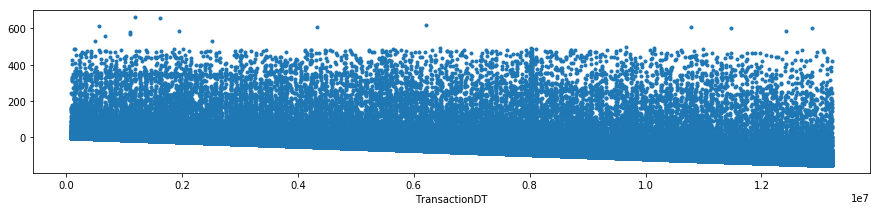

In [104]:
df_train_big['D3#norm'] = df_train_big['D3'] - df_train_big['TransactionDT']/86400
df_train_big.set_index('TransactionDT')['D3#norm'].plot(style='.', figsize=(15, 3))
plt.show()

In [17]:
to_drop = ['D2', 'D6', 'D12', 'D7']
to_add = ['email_domain#equal', 'D2#isnull', 'D12#isnull', 'D12#notzero', 'D7#isnull']
def newFeature(data):
    data['email_domain#equal'] = (data['P_emaildomain'] == data['R_emaildomain'])*1
    data['D2#isnull'] = data['D2'].isnull()*1
    data['D12#isnull'] = data['D12'].isnull()*1
    data['D12#notzero'] = (data['D12']>0) | (data['D12']<0)
    data['D7#isnull'] = data['D7'].isnull()*1
def newTinyFeature(data):
    data['D6_isnull#D12_notnull'] = data['D6'].isnull() & data['D12'].notnull()  #137/397=0.345
newFeature(df_train)
newFeature(df_test)
newFeature(df_test_oot)

In [278]:
count(df_trans, 'D9', 25)

(              total        1      rate
 D9                                    
  0.000000    4190.0    454.0  0.108353
  0.041666    3826.0    413.0  0.107946
  0.083333    3726.0    461.0  0.123725
  0.125000    3308.0    373.0  0.112757
  0.166666    2786.0    421.0  0.151113
  0.208333    1913.0    328.0  0.171458
  0.250000    1067.0    249.0  0.233365
  0.291666     663.0    206.0  0.310709
  0.333333     387.0    105.0  0.271318
  0.375000     323.0     99.0  0.306502
  0.416666     404.0     74.0  0.183168
  0.458333     733.0    115.0  0.156889
  0.500000    1278.0    110.0  0.086072
  0.541666    2327.0    111.0  0.047701
  0.583333    3644.0    212.0  0.058178
  0.625000    4380.0    262.0  0.059817
  0.666666    5069.0    380.0  0.074965
  0.708333    5132.0    414.0  0.080670
  0.750000    5147.0    473.0  0.091898
  0.791666    5388.0    516.0  0.095768
  0.833333    5273.0    502.0  0.095202
  0.875000    4857.0    517.0  0.106444
  0.916666    4694.0    499.0  0.106306


In [277]:
(df_trans['D8']*24).round().

count    74926.000000
mean      3505.394589
std       5559.932154
min          0.000000
25%         23.000000
50%        909.000000
75%       4511.000000
max      40987.000000
Name: D8, dtype: float64

In [279]:
df_trans['test'] = (df_trans['D8']*24).round()
count(df_trans, 'test', 1000)

(          total        1      rate
 test                              
  0.0     4190.0    454.0  0.108353
  1.0     3826.0    413.0  0.107946
  2.0     3726.0    461.0  0.123725
  3.0     3308.0    373.0  0.112757
  4.0     2786.0    421.0  0.151113
  5.0     1913.0    328.0  0.171458
  6.0     1067.0    249.0  0.233365
  7.0      663.0    206.0  0.310709
  8.0      387.0    105.0  0.271318
  9.0      323.0     99.0  0.306502
  10.0     404.0     74.0  0.183168
  11.0     733.0    115.0  0.156889
  12.0    1278.0    110.0  0.086072
  13.0    2327.0    111.0  0.047701
  14.0    3644.0    212.0  0.058178
  15.0    4380.0    262.0  0.059817
  16.0    5069.0    380.0  0.074965
  17.0    5132.0    414.0  0.080670
  18.0    5147.0    473.0  0.091898
  19.0    5388.0    516.0  0.095768
  20.0    5273.0    502.0  0.095202
  21.0    4857.0    517.0  0.106444
  22.0    4694.0    499.0  0.106306
  23.0    4411.0    533.0  0.120834
 NaN    515614.0  12836.0  0.024895, 0.43769744351667844)

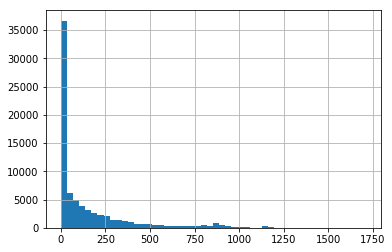

In [264]:
df_trans['D8'].hist(bins=50)

In [269]:
sorted(list(df_trans['D8'].unique()))

[nan,
 0.0,
 0.04166600108146668,
 0.08333300054073334,
 0.125,
 0.16666600108146667,
 0.20833300054073334,
 0.25,
 0.2916660010814667,
 0.3333329856395721,
 0.375,
 0.4166660010814667,
 0.4583329856395722,
 0.5,
 0.5416659712791443,
 0.5833330154418945,
 0.625,
 0.6666659712791443,
 0.7083330154418945,
 0.75,
 0.7916659712791443,
 0.8333330154418945,
 0.875,
 0.9166659712791444,
 0.9583330154418944,
 1.0,
 1.041666030883789,
 1.0833330154418943,
 1.125,
 1.166666030883789,
 1.2083330154418943,
 1.25,
 1.291666030883789,
 1.3333330154418943,
 1.375,
 1.416666030883789,
 1.4583330154418943,
 1.5,
 1.541666030883789,
 1.5833330154418943,
 1.625,
 1.666666030883789,
 1.7083330154418943,
 1.75,
 1.791666030883789,
 1.8333330154418943,
 1.875,
 1.916666030883789,
 1.9583330154418943,
 2.0,
 2.041666030883789,
 2.0833330154418945,
 2.125,
 2.166666030883789,
 2.2083330154418945,
 2.25,
 2.291666030883789,
 2.3333330154418945,
 2.375,
 2.416666030883789,
 2.4583330154418945,
 2.5,
 2.54166603

In [256]:
idx1 = (df_trans['D5'].isnull())
idx2 = (df_trans['D7'].isnull())
df_trans['test'] = idx1
print(count(df_trans, 'test', 10000))
df_trans['test'] = idx2
print(count(df_trans, 'test', 10000))

(        total      1      rate
test                          
False  280699  10880  0.038760
True   309841   9783  0.031574, 0.011278929491221919)
(        total      1      rate
test                          
False   38917   5790  0.148778
True   551623  14873  0.026962, 0.40902165596689594)


In [259]:
df_trans['test'] = (idx1)&(~idx2)
count(df_trans, 'test')

(        total      1      rate
 test                          
 False  585817  20514  0.035018
 True     4723    149  0.031548, 8.800969869036571e-05)

In [247]:
idx1 = (df_trans['D5']>0)|(df_trans['D5']<0)
idx2 = (df_trans['D7']>0)|(df_trans['D7']<0)
df_trans['test'] = idx1
print(count(df_trans, 'test', 10000))
df_trans['test'] = idx2
print(count(df_trans, 'test', 10000))

(        total      1      rate
test                          
False  375218  16421  0.043764
True   215322   4242  0.019701, 0.135879399178569)
(        total      1      rate
test                          
False  572758  19345  0.033775
True    17782   1318  0.074120, 0.028914394232484236)


In [250]:
df_trans['test'] = (idx1)&(~idx2)
count(df_trans, 'test')

(        total      1      rate
 test                          
 False  390399  17660  0.045236
 True   200141   3003  0.015004, 0.22762237763575374)

In [248]:
df_trans['test'] = idx1&idx2
count(df_trans, 'test')

(        total      1      rate
 test                          
 False  575359  19424  0.033760
 True    15181   1239  0.081615, 0.0331381957923428)

0


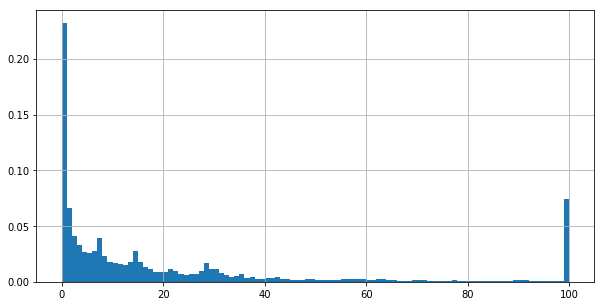

1


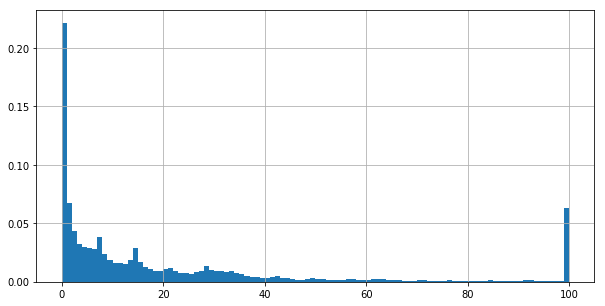

2


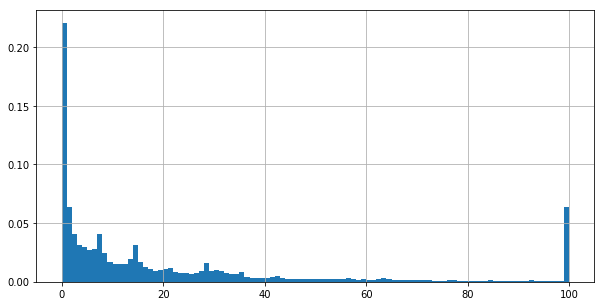

3


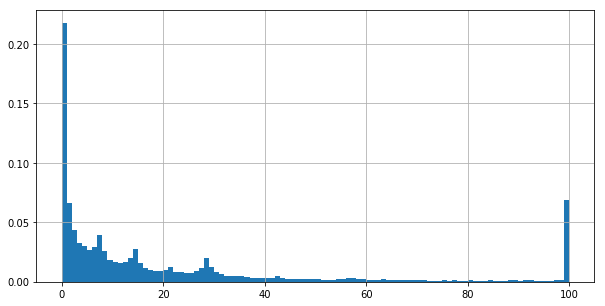

4


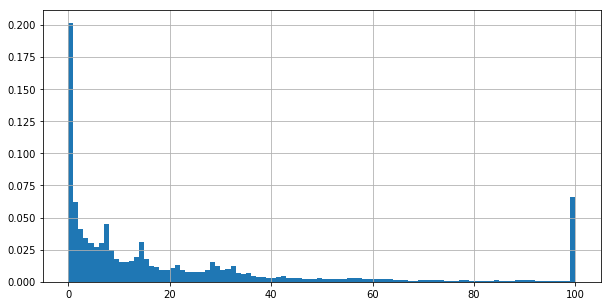

In [128]:
for i in range(5):
    print(i)
    tmp = df_trans_big[df_trans_big['#month']==i].set_index('TransactionDT')['D3'].clip(0, 100)
    tmp.hist(bins=100, figsize=(10, 5), density=True)
    plt.show()